# Integrador - Teoria de control

In [350]:
import sympy
from sympy.physics.control.lti import TransferFunction
import functools 
import copy
import numpy as np
from matplotlib import pyplot as plt

# Planteo del modelo
## Ecuaciones
Sean 

$\rarr$ x1: temperatura actual del sistema

$\rarr$ x2: Temperatura del resistor



In [351]:
from sympy.abc import s # Laplace var 
a,b,c,d,e= sympy.symbols("a,b,c,d,e") # State space var

A = sympy.Matrix([[a,b],[c,d]])
B = sympy.Matrix([[0],[e]])
C = sympy.Matrix([1,0]).T

### Matriz dinámica

In [352]:
A

Matrix([
[a, b],
[c, d]])

### Matriz de control

In [353]:
B

Matrix([
[0],
[e]])

### Matriz de salida

In [354]:
C

Matrix([[1, 0]])

## Funcion de transferencia

El calculo de la funcion de transferencia se hace a través de la formula:


$$
 H(s) = C{(sI - A)^{-1}}B + D
$$


In [355]:
temp = s * sympy.eye(A.shape[0]) - A # sI - A
inv = temp.inv()                  # (sI - A)^-1
temp = C * inv                  # C * (sI - A)^-1
H = temp * B                   # C * (sI - A)^-1 * B
transfer_function = H[0]      # Extract the result

num,den = sympy.fraction(sympy.factor(transfer_function)) # Factorize (factor) and extract numerator and denominator (fraction)
tf_expr = num/den   ##This is useful for jordan form

tf = TransferFunction(num,den,s)    # Create a transfer function object, which can be used for further analysis
tf

TransferFunction(b*e, a*d - a*s - b*c - d*s + s**2, s)

## Formas canonicas

Para el calculo de las formas canonicas, primero se preparan los datos para su facil manipulacion luego

In [356]:
den_args_str = [str(x) for x in den.args] # Extract terms from denominator
pow2 = [x for x in den_args_str if "s**2" in x] # Terms that have s ^ 2
pow1 = [x for x in den_args_str if "*s" in x and x not in pow2] # Terms that have s ^ 1
tail_terms = [x for x in den_args_str if x not in pow1 and x not in pow2] # Terms without s

pow1_expr =sympy.factor(sympy.parse_expr(functools.reduce(lambda a,b: a + b, pow1), evaluate=False)) # Join the terms
tail_terms_expr = sympy.factor(sympy.parse_expr(functools.reduce(lambda a,b: a + b, tail_terms), evaluate=False)) # Join the terms


def sanitize_expr_str(e):
    """
    Delete the s^2 and s^1 from the expression
    """
    start = e.find("s")
    if start == -1:
        return e 
    return e.replace(e[start:start+2:1], "")

# Find the coefficients a_0, a_1 and b_1
a_0 = sympy.parse_expr(sanitize_expr_str(str(tail_terms_expr)), evaluate=False)
a_1 =sympy.parse_expr(sanitize_expr_str(str(pow1_expr)), evaluate=False)
b_0 = 0
b_1 = num

### Forma canonica de control

In [357]:
A_ctrl = sympy.Matrix([[0,1], [-a_0, -a_1]])
B_ctrl = sympy.Matrix([[0], [1]])
C_ctrl = sympy.Matrix([b_1,b_0]).T

In [358]:
A_ctrl

Matrix([
[         0,     1],
[-a*d + b*c, a + d]])

In [359]:
B_ctrl

Matrix([
[0],
[1]])

In [360]:
C_ctrl

Matrix([[b*e, 0]])

### Forma observable
Transponemos A e intercambiamos B y C de la forma canonica de control

In [361]:
A_obs = copy.deepcopy(A_ctrl).T
B_obs = copy.deepcopy(C_ctrl)
C_obs = copy.deepcopy(B_ctrl).T

In [362]:
A_obs

Matrix([
[0, -a*d + b*c],
[1,      a + d]])

In [363]:
B_obs

Matrix([[b*e, 0]])

In [364]:
C_obs

Matrix([[0, 1]])

### Forma de Jordan

In [365]:
tf_poles = tf.poles()


In [366]:
tf_poles[0]


a/2 + d/2 - sqrt(a**2 - 2*a*d + 4*b*c + d**2)/2

In [367]:
tf_poles[1]


a/2 + d/2 + sqrt(a**2 - 2*a*d + 4*b*c + d**2)/2

Usando los polos encontrados:

In [368]:
A_jordan = sympy.Matrix([[tf_poles[0], 0], [0,tf_poles[1]]])
A_jordan

Matrix([
[a/2 + d/2 - sqrt(a**2 - 2*a*d + 4*b*c + d**2)/2,                                               0],
[                                              0, a/2 + d/2 + sqrt(a**2 - 2*a*d + 4*b*c + d**2)/2]])

In [369]:
B_jordan = sympy.ones(len(tf_poles),1)
B_jordan

Matrix([
[1],
[1]])

In [370]:
C_jordan = sympy.Matrix([        # Residue calculates the residue of the expression for a given pole
    sympy.residue(tf_expr, s, tf_poles[0]), 
    sympy.residue(tf_expr, s, tf_poles[1])
    ] ).T
C_jordan

Matrix([[-b*e/sqrt(a**2 - 2*a*d + 4*b*c + d**2), b*e/sqrt(a**2 - 2*a*d + 4*b*c + d**2)]])

## Asignando valores a los coeficientes
En la presente seccion, aplicamos valores a los coeficientes de modo de instanciar el sistema y poder obtener los resultados requeridos

Si bien creemos que la generalidad mostrada anteriormente es lo mas imporante del estudio, entendemos que para realizar el analisis es importante instanciar los coeficientes. 

### Ecuaciones
Como se observara, se tiene en cuenta que la inferencia de la temperatura del resistor sobre la tasa de cambio de la misma es nula.

In [371]:
a_value, b_value, c_value, d_value, e_value =-1,2,0,-2,1
# For simplicity, we replace the values in all matrices
A = A.subs({a:a_value, b:b_value, c:c_value, d:d_value, e:e_value})
B = B.subs({a:a_value, b:b_value, c:c_value, d:d_value, e:e_value})
C = C.subs({a:a_value, b:b_value, c:c_value, d:d_value, e:e_value})

#### Matriz dinámica

In [372]:
A

Matrix([
[-1,  2],
[ 0, -2]])

#### Matriz de control

In [373]:
B

Matrix([
[0],
[1]])

#### Matriz de salida

In [374]:
C

Matrix([[1, 0]])

### Funcion de transferencia

In [375]:
tf = tf.evalf(subs={a:a_value, b:b_value, c:c_value, d:d_value, e:e_value})
tf

TransferFunction(2.0, s**2 + 3.0*s + 2.0, s)

In [376]:
tf.poles()

[-2.00000000000000, -1.00000000000000]

### Formas canonicas

In [377]:
a_0 = a_0.evalf(subs={a:a_value, b:b_value, c:c_value, d:d_value, e:e_value})
a_1 = a_1.evalf(subs={a:a_value, b:b_value, c:c_value, d:d_value, e:e_value})
b_1 = b_1.evalf(subs={a:a_value, b:b_value, c:c_value, d:d_value, e:e_value})
[a_0, a_1, b_1]

[2.00000000000000, 3.00000000000000, 2.00000000000000]

#### Forma canonica de control

In [378]:
A_ctrl = A_ctrl.subs({a:a_value, b:b_value, c:c_value, d:d_value, e:e_value})
B_ctrl = B_ctrl.subs({a:a_value, b:b_value, c:c_value, d:d_value, e:e_value})
C_ctrl = C_ctrl.subs({a:a_value, b:b_value, c:c_value, d:d_value, e:e_value})

In [379]:
A_ctrl

Matrix([
[ 0,  1],
[-2, -3]])

In [380]:
B_ctrl

Matrix([
[0],
[1]])

In [381]:
C_ctrl

Matrix([[2, 0]])

#### Forma canonica observable

In [382]:
A_obs = A_obs.subs({a:a_value, b:b_value, c:c_value, d:d_value, e:e_value})
B_obs = B_obs.subs({a:a_value, b:b_value, c:c_value, d:d_value, e:e_value})
C_obs = C_obs.subs({a:a_value, b:b_value, c:c_value, d:d_value, e:e_value})

In [383]:
A_obs

Matrix([
[0, -2],
[1, -3]])

In [384]:
B_obs

Matrix([[2, 0]])

In [385]:
C_obs

Matrix([[0, 1]])

#### Forma canonica de Jordan

In [386]:
A_jordan = A_jordan.subs({a:a_value, b:b_value, c:c_value, d:d_value, e:e_value})
B_jordan = B_jordan.subs({a:a_value, b:b_value, c:c_value, d:d_value, e:e_value})
C_jordan = C_jordan.subs({a:a_value, b:b_value, c:c_value, d:d_value, e:e_value})

In [387]:
A_jordan

Matrix([
[-2,  0],
[ 0, -1]])

In [388]:
B_jordan

Matrix([
[1],
[1]])

In [389]:
C_jordan

Matrix([[-2, 2]])

# Solucion del modelo
En esta fase, realizaremos el analisis de la estabilidad, controlabilidad y observabilidad del sistema.
## Laplace
Si bien ya hemos mostrado anteriormente cual es la transformada de Laplace de nuestro sistema, volvemos a revisarla para hacer un analisis mas exaustivo.

In [390]:
tf

TransferFunction(2.0, s**2 + 3.0*s + 2.0, s)

### Ceros y polos del sistema
A simple vista, podemos observar que nuestro sistema no tiene ceros, sin embargo para dejar ejemplificado como se buscarian, adjuntamos el desarrollo aqui debajo.

In [391]:
tf.zeros()

[]

In [392]:
tf.poles()

[-2.00000000000000, -1.00000000000000]

### Tipo del sistema
El sistema es de tipo 0, ya que no presenta polos en el origen. 

## Respuesta del sistema ante diferentes entradas

### Escalon

In [394]:
t = sympy.symbols("t", positive=True) # Time var
TEMPERATURE = 50 # Temperature in Celsius

In [395]:
laplace_step = TEMPERATURE/s # Laplace transform of the step function
step = sympy.inverse_laplace_transform(tf.to_expr() * laplace_step, s, t)
step

50.0 + 50.0*exp(-2.0*t) - 100.0*exp(-1.0*t)

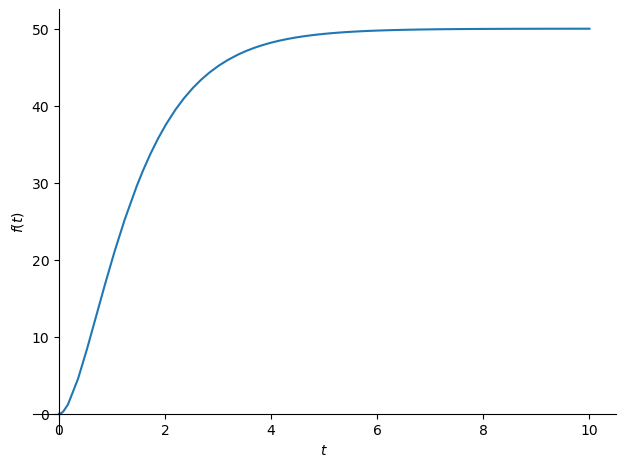

In [396]:
sympy.plot(step, (t, 0, 10))

### Rampa

In [397]:
laplace_ramp = TEMPERATURE/s**2 # Laplace transform of the ramp function
ramp = sympy.inverse_laplace_transform(tf.to_expr() * laplace_ramp, s, t)
ramp

50.0*t - 75.0 - 25.0*exp(-2.0*t) + 100.0*exp(-1.0*t)

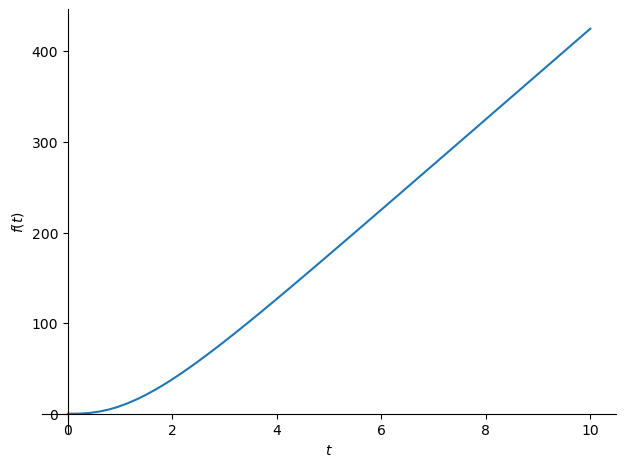

In [398]:
sympy.plot(ramp, (t, 0, 10))

### Parabola

In [399]:
laplace_quadratic = TEMPERATURE/s**3 # Laplace transform of the quadratic function
quadratic = sympy.inverse_laplace_transform(tf.to_expr() * laplace_quadratic, s, t)
quadratic

25.0*t**2 - 75.0*t + 87.5 + 12.5*exp(-2.0*t) - 100.0*exp(-1.0*t)

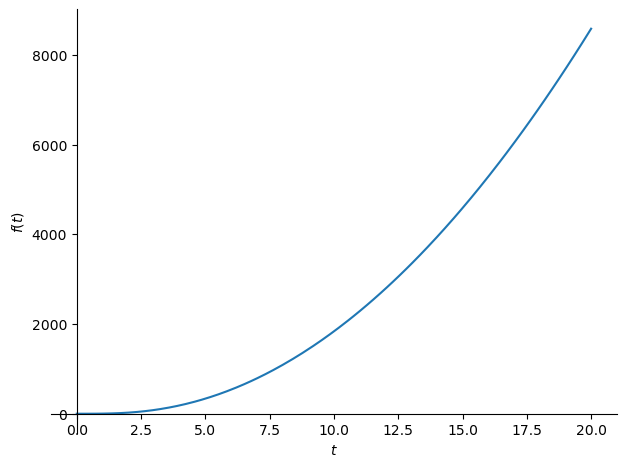

In [400]:
sympy.plot(quadratic, (t, 0, 20))

### Conclusion
Como podiamos llegar a anticipar, es conveniente utilizar la funcion escalon, con la temperatura deseada por el usuario a fin de estabilizar el sistema para dicha temperatura, el resto de entradas, nos dan una respuesta que tiende a infinito, haciendo el sistema completamente inestable.  

## Plano de fase


In [401]:
phases_matrix = sympy.Matrix([s*sympy.eye(A.shape[0]) - A]).inv()
phases_matrix = sympy.inverse_laplace_transform(phases_matrix, s, t)
phases_matrix
x_1_0 = 2
x_2_0 = 2
x_0 = sympy.Matrix([x_1_0, x_2_0])
phase_x = phases_matrix @ x_0

In [402]:
phase_x

Matrix([
[2*(2*exp(t) - 2)*exp(-2*t) + 2*exp(-t)],
[                           2*exp(-2*t)]])

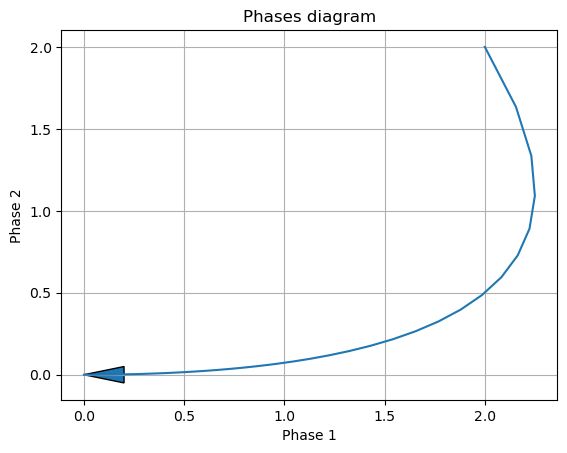

In [403]:
def getArrayPhase(phase, time):
    """
    Convert sympy expression to numpy array
    """
    return np.array([phase.subs({t:t_i}) for t_i in time])
def plot_phases(phase_1, phase_2):
    """
    Plot the phases
    """
    plt.plot(phase_1, phase_2)
    plt.xlabel("Phase 1")
    plt.ylabel("Phase 2")
    plt.title("Phases diagram")
    plt.arrow(float(phase_1[-1]), 
              float(phase_2[-1]),
              float(phase_1[-1]-phase_1[-2]) ,
              float(phase_2[-1]-phase_2[-2]), 
              head_width=0.1, 
              head_length=0.2,
              length_includes_head=True)
    plt.grid()
    plt.show()

phase_x1 = getArrayPhase(phase_x[0], np.linspace(0, 10, 100))
phase_x2 = getArrayPhase(phase_x[1], np.linspace(0, 10, 100))
plot_phases(phase_x1, phase_x2)


## Grafica de trayectorias

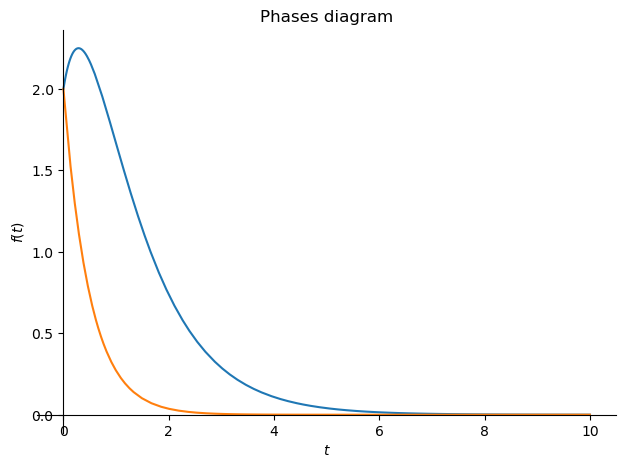

In [404]:
sympy.plot(phase_x[0],phase_x[1], (t, 0, 10), title="Phases diagram")

### Diagrama de lugar de raices


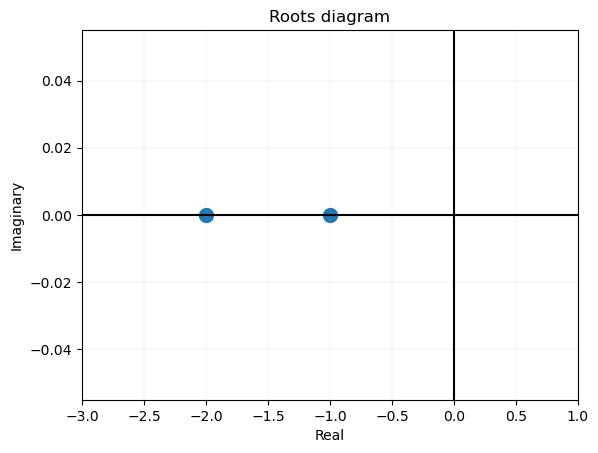

In [405]:
def plotRoots(roots):
    """
    Plot the roots
    """
    plt.scatter(np.real(roots), np.imag(roots),s=100)
    plt.xlabel("Real")
    plt.ylabel("Imaginary")
    plt.title("Roots diagram")
    plt.xlim(-3,1)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.grid(linewidth=0.1)
    plt.show()
plotRoots(tf.poles())